In [1]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from snscrape.modules import twitter 

In [3]:
import datetime as dt

def create_dates():
    current_year = dt.datetime.now().date().strftime("%Y") 
    prev_year = str(int(current_year)-1)
    date = dt.datetime.now().date().strftime(r"%m-%d")
    current_date = current_year+"-"+date 
    prev_date = prev_year+"-"+date 

    return (current_date, prev_date)

create_dates()

('2022-06-02', '2021-06-02')

In [4]:
### Get 200 tweets from twitter user

import pandas as pd
import time

until, since = create_dates()
query = "(from:BillGates) until:{} since:{}".format(until, since)
# query = "(from:BillGates)"
limit = 1000
tweets = []

s = time.time()

for tweet in twitter.TwitterSearchScraper(query).get_items():
    if len(tweets) == limit:
        break
    else:
        try:
            tweets.append([tweet.date.date(), tweet.content, tweet.user.username, tweet.url])
        except:
            tweets.append([tweet.date.date(), tweet.content, tweet.username, tweet.url])

        # print(vars(tweet))
        # break

print(time.time() - s)

dataset = pd.DataFrame(tweets, columns=["Date", "Content", "Username", "URL"])

5.941885471343994


In [5]:
dataset.shape

(334, 4)

In [6]:
(dataset['Username']=='BillGates').unique() # check if all tweets are from the required user

array([ True])

In [7]:
### clean the text

import re

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove @mentions
    text = re.sub(r'#', '', text) # remove hashtags
    text = re.sub(r'RT[\s]+', '', text) # remove retweets
    text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlinks
    text = re.sub(r'\n', ' ', text) # remove newlines '\n'

    return text

df = pd.DataFrame()
df['Tweets'] = dataset['Content'].apply(clean_text)
df['Month'] = dataset['Date'].apply(lambda x: x.strftime("%B"))
df['Tweets']

0      To meet the world’s climate goals, clean energ...
1      Just like we have a robust system to prevent a...
2      I can’t believe this was 15 years ago. I alway...
3        Reconnecting with Steve was fantastic. And f...
4                                          Incredible.  
                             ...                        
329    These young leaders make me optimistic that br...
330    Against the odds,  became a doctor and is help...
331    This is an important step in the U.S. clean en...
332    Heroes like Dr. Mohamed Barrie are the reason ...
333    This partnership between  Energy and the _Comm...
Name: Tweets, Length: 334, dtype: object

In [8]:
# Get sentiments
from textblob import TextBlob

# Get subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Get polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['Tweets'].apply(get_subjectivity)
df['Polarity'] = df['Tweets'].apply(get_polarity)

df

,Tweets,Month,Subjectivity,Polarity
0,"To meet the world’s climate goals, clean energ...",June,0.691667,0.513889
1,Just like we have a robust system to prevent a...,June,0.566667,0.500000
2,I can’t believe this was 15 years ago. I alway...,June,0.700000,0.500000
3,Reconnecting with Steve was fantastic. And f...,June,0.616667,0.325000
4,Incredible.,May,0.900000,0.900000
...,...,...,...,...
329,These young leaders make me optimistic that br...,June,0.400000,0.100000
330,"Against the odds, became a doctor and is help...",June,0.750000,0.750000
331,This is an important step in the U.S. clean en...,June,0.816667,0.380556
332,Heroes like Dr. Mohamed Barrie are the reason ...,June,0.500000,0.333333


In [9]:
### Compute the negative, neutral and positive analysis

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)

In [10]:
df = df.sort_values(by=['Polarity'])

In [11]:
positive_tweets = (df[df['Analysis']=='Positive'])
positive_tweets

,Tweets,Month,Subjectivity,Polarity,Analysis
298,Ever heard a toilet be compared to an espresso...,August,0.100000,0.011111,Positive
10,"Not long ago, the world increased aid for glob...",May,0.200000,0.012500,Positive
28,Katalin Kariko () saw the potential of mRNA to...,May,0.616667,0.016667,Positive
278,I applaud David Vélez and Mariel Reyes’s pledg...,August,0.350000,0.025000,Positive
256,But the fact that we can point to positive sig...,September,0.474242,0.026768,Positive
...,...,...,...,...,...
170,I read a lot of great books this year. These w...,November,0.750000,0.800000,Positive
4,Incredible.,May,0.900000,0.900000,Positive
307,"During the height of the U.S. polio epidemic, ...",July,1.000000,1.000000,Positive
61,One of the best parts of my job is learning fr...,April,0.650000,1.000000,Positive


In [12]:
negative_tweets = (df[df['Analysis']=='Negative'])
negative_tweets

,Tweets,Month,Subjectivity,Polarity,Analysis
133,mRna vaccines still can't meet all the demand...,January,1.000000,-0.500000,Negative
205,In addition to investments in reducing emissio...,November,0.400000,-0.300000,Negative
168,There’s lots of speculation about what Shakesp...,November,0.200000,-0.300000,Negative
228,"Still, the disparities in access to the COVID-...",October,0.650000,-0.250000,Negative
116,The omicron surge is an unfortunate reminder t...,January,1.000000,-0.250000,Negative
259,"When the pandemic hit, many feared the worst w...",September,0.625000,-0.208333,Negative
47,To avoid another COVID-19 – or worse – the wor...,April,0.612500,-0.200000,Negative
149,The big unknown is how sick omicron makes you....,December,0.654497,-0.190476,Negative
173,About 3.6 billion people—nearly half of the wo...,November,0.166667,-0.166667,Negative
127,People like you and I and Tony Fauci have ...,January,0.333333,-0.166667,Negative


In [13]:
neutral_tweets = (df[df['Analysis']=='Neutral'])
neutral_tweets

,Tweets,Month,Subjectivity,Polarity,Analysis
202,"Thank you, . This $1B partnership between Ene...",November,0.800000,0.0,Neutral
60,This rocks.,April,0.000000,0.0,Neutral
216,India has administered 1 billion vaccine doses...,October,0.000000,0.0,Neutral
230,The pandemic has worsened inequities. But it's...,October,1.000000,0.0,Neutral
231,This work has been critical to our understandi...,October,0.800000,0.0,Neutral
214,The world needs heroes like Shumaila Rehmani. ...,October,0.000000,0.0,Neutral
196,Public-private collaborations will be critical...,November,0.800000,0.0,Neutral
115,To have any hope of reaching net zero and halt...,January,0.210417,0.0,Neutral
194,I was truly inspired to hear speak at COP26 t...,November,0.000000,0.0,Neutral
191,Demand for syringes has skyrocketed to deliver...,November,0.300000,0.0,Neutral


In [14]:
positive_tweets_count = positive_tweets.shape[0]
negative_tweets_count = negative_tweets.shape[0]
neutral_tweets_count = neutral_tweets.shape[0]

In [15]:
(positive_tweets_count+negative_tweets_count+neutral_tweets_count) == df.shape[0]

True

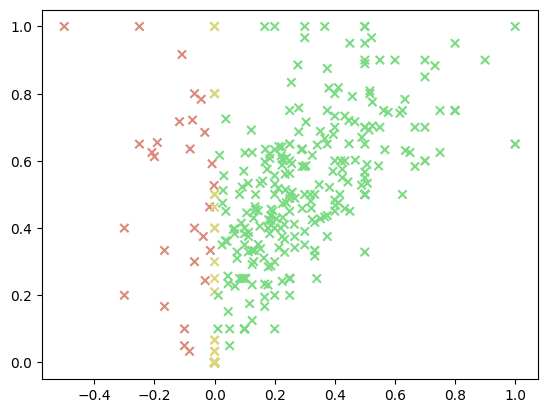

In [16]:
# plot scatter graph of polarity and subjectivity

def get_plot_color(analysis):
    if analysis == 'Positive':
        return '#7bdb83'
    elif analysis == 'Negative':
        return '#db897b'
    else:
        return '#dbd57b'
# def get_plot_color(analysis):
#     if analysis == 'Positive':
#         return '#05f551'
#     elif analysis == 'Negative':
#         return '#f54105'
#     else:
#         return '#05cdf5'

from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
plt.style.use('default')
df['Color'] = df['Analysis'].apply(get_plot_color)
plt.scatter(df['Polarity'], df['Subjectivity'], c=df['Color'], marker=MarkerStyle(marker='x', fillstyle='none'))
plt.show()


In [17]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [18]:
# percentages of sentiments

positive_tweets_percentage = round((positive_tweets_count / df.shape[0])*100, 1)
negative_tweets_percentage = round((negative_tweets_count / df.shape[0])*100, 1)
neutral_tweets_percentage = round((neutral_tweets_count / df.shape[0])*100, 1)

In [19]:
(neutral_tweets_percentage+negative_tweets_percentage+positive_tweets_percentage) #random check

100.0

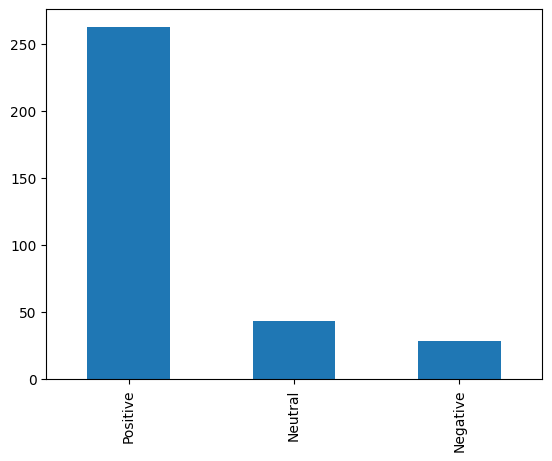

In [20]:
df['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [21]:
!pip install calender

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement calender (from versions: none)
ERROR: No matching distribution found for calender


In [22]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_wise_positive_tweets = positive_tweets.groupby(['Month']).agg({
    "Tweets": 'count'}).reindex(months)
# month_wise_positive_tweets = month_wise_positive_tweets.reindex(months)
month_wise_positive_tweets

,Tweets
Month,
January,24
February,8
March,16
April,21
May,32
June,18
July,16
August,28
September,28


In [23]:
month_wise_negative_tweets = negative_tweets.groupby(['Month']).agg({
    "Tweets": 'count'}).reindex(months)

In [24]:
month_wise_neutral_tweets = neutral_tweets.groupby(['Month']).agg({
    "Tweets": 'count'}).reindex(months)

In [25]:
import numpy as np
x = np.arange(len(months))  # the label locations
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

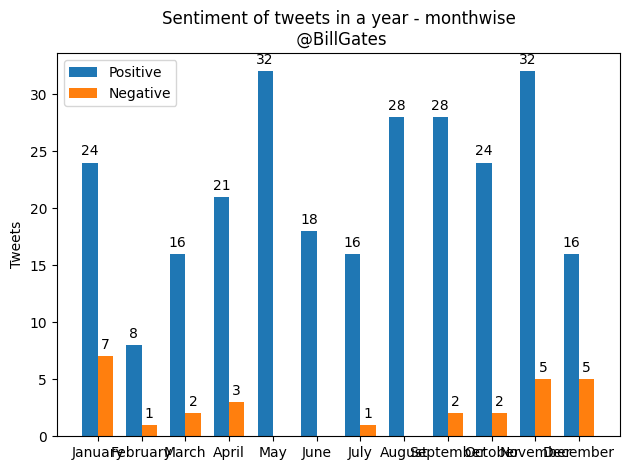

In [28]:

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, month_wise_positive_tweets['Tweets'], width, label='Positive')
rects2 = ax.bar(x + width/2, month_wise_negative_tweets['Tweets'], width, label='Negative')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Tweets')
ax.set_title('Sentiment of tweets in a year - monthwise\n @BillGates')
ax.set_xticks(x, months)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()